<a href="https://colab.research.google.com/github/varsenii/AI/blob/main/CT_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scipy
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.29-cp37-none-any.whl size=8614 sha256=ebeaf7cb9d36753a847cb626ff14f736b75c703f450e7792c1cd9794248a20e5
  Stored in directory: /root/.cache/pip/wheels/8b/cb/fb/cbeba24d72e736b8987b7d0dc37afc0e76f3c16e544ceff727
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-cp37-none-any.whl size=7610 sha256=f0c651242113065ecb3bbfc65c71991507a410ddaf84bba7a2868b0a20762cef
  Stored in directory: /root/.cache/pip/wheels/2a/62/31/d348320becc60729f508a2c5aad445b94d7543c5cb577cfb9d
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=ae6700edcd6e7e3d8cef1ac07014e396df682f5e597003f85333e15d6ef23999
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [4]:
import os
import shutil
from zipfile import ZipFile
from collections import Counter
import pandas as pd
import numpy as np
import math
import json
from scipy import stats, ndimage, interpolate, signal
from scipy.optimize import fsolve
from sklearn.model_selection import train_test_split

import cv2
import skimage
from skimage import measure
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, BatchNormalization, GlobalAveragePooling3D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from plot_keras_history import plot_history

In [5]:
%cd "/content/drive/MyDrive/Programming/Machine Learning/Covid multimodal classification"

/content/drive/MyDrive/Programming/Machine Learning/Covid multimodal classification


# Data exploration

In [6]:
PATIENTS_DIR = './data/iCTCF/Patients'
PREPROCESSED_DIR = './data/iCTCF/PreproccesedCT'

In [7]:
feature_frame = pd.read_excel('./data/iCTCF/imputed_data_dec_True.xlsx')
for i in feature_frame.index:
  id = feature_frame.at[i, 'id']
  id = id.replace('_', ' ')
  feature_frame.at[i, 'id'] = id

feature_frame

,id,Label1-Mortality outcome,Label2-SARS-CoV-2 nucleic acids,Age,Body temperature,Gender,Dementia,Brain surgery,Brain stem hemorrhage,Cerebral atherosclerosis,Cerebral hemorrhage,Cerebral infarction,Intracranial aneurysm,Lacunar infarction,Aphasia,Organic mental disorders,Pituitary adenoma,Subdural effusion,Subdural hemorrhage,Parkinson Disease,Encephalopathy,Myasthenia gravis,Gastrointestinal surgery for neoplasia,Adjuvant Chemotherapy for gastrointestinal tumor,Intestinal obstruction,Radio-chemotherapy,Gastritis,Non specified chronic stomach disease,Gastrointestinal bleeding,Gastrointestinal Ulcer,Gastroesophageal reflux,Gastric cancer,Inguinal hernia,Gastrointestinal surgery,Arrhythmia,Coronary disease,Heart failure,Cardiomyopathy,Hypertension,Hypertensive heart disease,...,TT Value in range,FIB Value,FIB Value in range,APTT Value,APTT Value in range,INR Value,INR Value in range,PT Value,PT Value in range,ALP Value,ALP Value in range,ALT Value,ALT Value in range,AST Value,AST Value in range,CA Value,CA Value in range,CL Value,CL Value in range,CO2 Value,CO2 Value in range,CREA Value,CREA Value in range,GLB Value,GLB Value in range,K Value,K Value in range,MG Value,MG Value in range,Na Value,Na Value in range,PHOS Value,PHOS Value in range,TBIL Value,TBIL Value in range,TP Value,TP Value in range,URIC Value,URIC Value in range,Unnamed: 252
0,Patient 1,Cured,Positive,81,36.6,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1.230000,1,0.677419,0,0.607843,0,0.6200,0,0.109091,0,1.657143,1,1.125000,1,0.098039,0,0.483333,0,0.988889,0,0.340449,0,0.90000,0,0.382353,0,0.600000,0,0.566667,0,0.015152,0,0.338129,0,-0.015789,-1,0.299091,0,78
1,Patient 2,Cured,Positive,50,38.7,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1.410000,1,1.012903,1,0.215686,0,0.2000,0,-0.036364,-1,1.285714,1,1.156250,1,0.509804,0,0.325000,0,-0.422222,-1,0.349438,0,0.59000,0,0.482353,0,0.275000,0,0.244444,0,0.545455,0,0.316547,0,0.147368,0,0.610455,0,78
2,Patient 3,Cured,Positive,65,38.5,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.635400,0,0.601679,0,0.467386,0,0.4800,0,0.036364,0,1.542857,1,1.718750,1,-0.509804,-1,0.750000,0,0.255556,0,0.269663,0,1.21000,1,0.076471,0,0.450000,0,0.622222,0,0.090909,0,-0.028777,-1,-0.100000,-1,0.402727,0,78
3,Patient 4,Cured,Positive,73,38.5,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1.385000,1,0.696774,0,0.274510,0,0.2800,0,0.236364,0,0.857143,0,1.218750,1,0.039216,0,0.350000,0,0.100000,0,0.424719,0,0.64000,0,0.682353,0,0.275000,0,0.133333,0,-0.348485,-1,0.323741,0,-0.310526,-1,0.155909,0,78
4,Patient 5,Cured,Positive,64,38.0,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.753367,0,0.521526,0,0.490196,0,0.5000,0,0.225305,0,0.335347,0,0.373590,0,0.267801,0,0.498645,0,0.382378,0,0.158858,0,0.53385,0,0.276455,0,0.369435,0,0.359689,0,0.266818,0,0.433222,0,-0.079335,-1,0.292060,0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,Patient 1517,Unknown,Positive,45,38.9,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2.380000,1,0.935484,0,0.823529,0,0.8400,0,0.172727,0,2.600000,1,1.125000,1,0.117647,0,0.341667,0,0.511111,0,0.096629,0,1.22000,1,0.629412,0,0.675000,0,0.333333,0,0.227273,0,0.251799,0,0.121053,0,-0.049545,-1,78
1517,Patient 1518,Unknown,Positive,66,36.6,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.649833,0,0.519263,0,0.490196,0,0.5000,0,0.273770,0,0.516920,0,0.423088,0,0.397199,0,0.489244,0,0.539678,0,0.211200,0,0.40990,0,0.342931,0,0.403222,0,0.362956,0,0.241364,0,0.406898,0,-0.190209,-1,0.339020,0,78
1

There are patients having multiple ct scans or an X-ray image. Only the biggest ct scan (more slices) will be used for the classification

In [ ]:
MULTIPLE_SCANS_PATIENS = {}
for patient_zip in os.listdir(PATIENTS_DIR):
  patient_path = os.path.join(PATIENTS_DIR, patient_zip)
  with ZipFile(patient_path, 'r') as zip:
    scan_names = []
    for img_path in zip.namelist():
      try:
        scan_name = img_path.split('/')[-1].split('-')[1]
        scan_names.append(scan_name)
      except (IndexError):
        pass
    if len(set(scan_names)) > 1:
      patient_id = patient_zip.split('.zip')[0]
      scan_names = ['IMG-'+scan for scan in scan_names]
      print('\n' + patient_id)
      print(dict(Counter(scan_names)))
      biggest_scan = sorted(dict(Counter(scan_names)).items(), key=lambda item: item[1])[-1][0]
      MULTIPLE_SCANS_PATIENS[patient_id] = biggest_scan
      
with open('./data/multiple_scans_patients.txt', 'w') as f:
  json.dump(MULTIPLE_SCANS_PATIENS, f)


Patient 1072
{'IMG-0001': 1, 'IMG-0002': 53, 'IMG-0003': 61, 'IMG-0004': 188, 'IMG-0005': 242}

Patient 927
{'IMG-0001': 1, 'IMG-0002': 284}

Patient 836
{'IMG-0001': 1, 'IMG-0002': 64, 'IMG-0003': 64, 'IMG-0004': 214, 'IMG-0005': 267}

Patient 208
{'IMG-0001': 1, 'IMG-0002': 379}

Patient 220
{'IMG-0001': 1, 'IMG-0002': 399}

Patient 230
{'IMG-0001': 1, 'IMG-0002': 471}


In [16]:
with open('./data/multiple_scans_patients.txt', 'r') as f:
  MULTIPLE_SCANS_PATIENS = json.load(f)
MULTIPLE_SCANS_PATIENS

{'Patient 1072': 'IMG-0005',
 'Patient 208': 'IMG-0002',
 'Patient 220': 'IMG-0002',
 'Patient 230': 'IMG-0002',
 'Patient 836': 'IMG-0005',
 'Patient 927': 'IMG-0002'}

## Slice distribution

In [17]:
with open('./data/multiple_scans_patients.txt', 'r') as f:
  MULTIPLE_SCANS_PATIENS = json.load(f)
MULTIPLE_SCANS_PATIENS

{'Patient 1072': 'IMG-0005',
 'Patient 208': 'IMG-0002',
 'Patient 220': 'IMG-0002',
 'Patient 230': 'IMG-0002',
 'Patient 836': 'IMG-0005',
 'Patient 927': 'IMG-0002'}

Slices per patient:
Min: 51
Max: 539
Mean: 270
Mode: 379
SD: 113


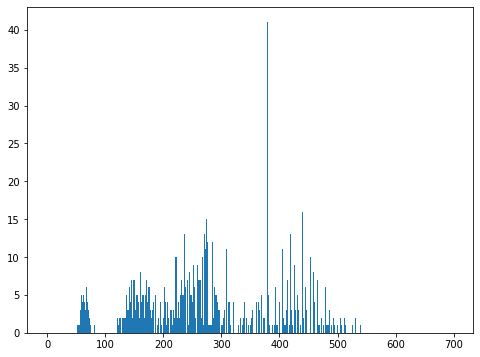

In [30]:
slices_per_patient = []

for patient_zip in os.listdir(PATIENTS_DIR):
  patient_id = patient_zip.split('.zip')[0]
  patient_path = os.path.join(PATIENTS_DIR, patient_zip)
  with ZipFile(patient_path, 'r') as zip:
    img_names = zip.namelist()
    if patient_id in MULTIPLE_SCANS_PATIENS:
      img_names = [img_name for img_name in img_names if MULTIPLE_SCANS_PATIENS[patient_id] in img_name]
    slices_per_patient.append(len(img_names))


print("Slices per patient:")
print("Min: {}".format(min(slices_per_patient)))
print("Max: {}".format(max(slices_per_patient)))
print("Mean: {}".format(int(np.floor(np.mean(slices_per_patient)))))
print('Mode: {}'.format(stats.mode(slices_per_patient)[0][0]))
print("SD: {}".format(int(np.floor(np.std(slices_per_patient)))))

x = sorted(slices_per_patient)
fig = plt.figure(figsize = (8, 6))
plt.hist(x, bins = np.arange(0, 700, 1))
plt.show()

In [32]:
for patient_zip in os.listdir(PATIENTS_DIR):
  patient_id = patient_zip.split('.zip')[0]
  patient_path = os.path.join(PATIENTS_DIR, patient_zip)
  with ZipFile(patient_path, 'r') as zip:
    img_names = zip.namelist()
    if patient_id in MULTIPLE_SCANS_PATIENS:
      img_names = [img_name for img_name in img_names if MULTIPLE_SCANS_PATIENS[patient_id] in img_name]
    if len(img_names) == 51:
      print('Patient with the fewest slices: ', patient_id)
    if len(img_names) == 539:
      print('Patient with the most slices: ', patient_id)

Patient with the fewest slices:  Patient 337
Patient with the fewest slices:  Patient 368
Patient with the fewest slices:  Patient 644
Patient with the most slices:  Patient 1377
Patient with the fewest slices:  Patient 86


# Data preprocessing and storage

## Body cropping

In [8]:
def crop(img):
  thr, img_thr= cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  img_test = measure.label(img_thr, connectivity = 1) # prendo le regioni binarie nell'immagine
  props = measure.regionprops(img_test) 

  areas=[prop.area for prop in props] #prendo le aree di tutte le regioni
  ind_max_area=np.argmax(areas)+1 #prendo la regione con area massima (cilindro del corpo)

  boxes = [prop.bbox for prop in props] #prendo le aree di tutte le regioni
  min_ax_length = props[ind_max_area -1].minor_axis_length
  max_ax_length = props[ind_max_area - 1].major_axis_length
  box = boxes[ind_max_area-1]
  img_new = img[box[0]:box[2], box[1]:box[3]]
  thr, img_thr= cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  return img_new

In [9]:
def padding(img, offset):
  cv2.copyMakeBorder(img, img, offset, offset, offset, offset, cv2.BORDER_CONSTANT, value = 0)
  return img

def fillhole(input_image):
  img_fill_holes = ndimage.binary_fill_holes(input_image).astype(int)
  return img_fill_holes

def segment_lungs(img):
  return np.bitwise_and(fillhole(img > 128), img < 128)

In [10]:
def to_square_shape(img):
  dim = min(img.shape[0], img.shape[1])
  padding = int(dim * 0.2)
  img = cv2.copyMakeBorder(img, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=0)
  dim = min(img.shape[0], img.shape[1])

  left = (img.shape[1] - dim) // 2
  right = (img.shape[1] + dim) // 2
  top = (img.shape[0] + dim) // 2
  bottom = (img.shape[0] - dim) // 2
  img = img[bottom:top, left:right]
  return img

In [176]:
TEST_IMG_PATH = './data/iCTCF/test_image.jpg'
src_zip_path = os.path.join(PATIENTS_DIR, 'Patient 715.zip')
target_dir = './data/test/segmented/Patient 715'

if not os.path.exists(target_dir):
  os.makedirs(target_dir)

with ZipFile(src_zip_path, 'r') as zip:
  for img_name in zip.namelist():
    img_path = zip.extract(img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = crop(img)
    img = segment_lungs(img)
    img = to_square_shape(img)
    img *= 255
    img_name = img_name.split('/')[-1]
    cv2.imwrite(os.path.join(target_dir, img_name), img)

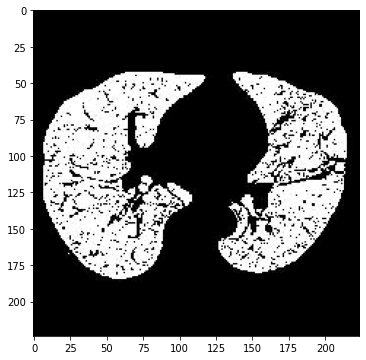

255

In [151]:
img = load_img('./data/iCTCF/cropped test image.jpg', color_mode='grayscale', target_size=(224, 224))

# img = np.resize(img, (224, 224))

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.show()

np.max(img)

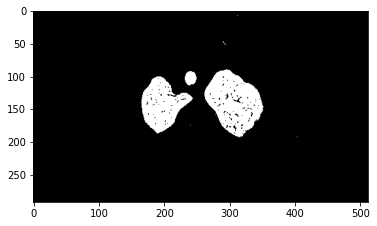

In [ ]:
path = POSITIVE_DIR + "/Patient 67/IMG-0001-00039.jpg"

img = cv2.imread(path)
img = crop(img)
# print(np.sum(img > 0))
# img = fillhole(img > 128)
img = segment_lungs(img)
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# n_positive = 100

# if not os.path.exists(POSITIVE_DIR):
#   os.makedirs(POSITIVE_DIR)

# for patient_zip in os.listdir(PATIENTS_DIR):
#   patient_id = patient_zip.replace('.zip', '')
#   label = feature_frame.loc[feature_frame['id'] == patient_id]['Label2-SARS-CoV-2 nucleic acids'].values[0]
#   if label == 'Positive':
#     if not patient_id in os.listdir(POSITIVE_DIR):
#       zip_path = os.path.join(PATIENTS_DIR, patient_zip)
#       segment_from_zip(zip_path, POSITIVE_DIR)
#     n_positive -= 1
    
#   if n_positive == 0:
#       break

In [ ]:
# n_negative = 100

# if not os.path.exists(NEGATIVE_DIR):
#   os.makedirs(NEGATIVE_DIR)

# for patient_zip in os.listdir(PATIENTS_DIR):
#   patient_id = patient_zip.replace('.zip', '')
#   label = feature_frame.loc[feature_frame['id'] == patient_id]['Label2-SARS-CoV-2 nucleic acids'].values[0]
#   if label == 'Negative':
#     if not patient_id in os.listdir(NEGATIVE_DIR):
#       zip_path = os.path.join(PATIENTS_DIR, patient_zip)
#       segment_from_zip(zip_path, NEGATIVE_DIR)
#     n_negative -= 1

#   if n_negative == 0:
#     break

## Segmentation

In [ ]:
# def crop(img):
#   img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#   thr, img_thr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#   img_test = measure.label(img_thr, connectivity = 1) # prendo le regioni binarie nell'immagine
#   props = measure.regionprops(img_test) 
#   areas = [prop.area for prop in props] #prendo le aree di tutte le regioni
#   ind_max_area = np.argmax(areas)+1 #prendo la regione con area massima (cilindro del corpo)

#   boxes = [prop.bbox for prop in props] #prendo le aree di tutte le regioni
#   box = boxes[ind_max_area-1]
#   img_new = img[box[0]:box[2], box[1]:box[3]]
#   return img_new

## Defining a threshold

In [ ]:
def lungs_relative_areas(imgs_path):
  slices = os.listdir(imgs_path)
  y = []
  for slice_name in slices:
    slice_path = os.path.join(imgs_path, slice_name)
    slice = cv2.imread(slice_path)
    slice = crop(slice)
    body_area = np.sum(slice > 0)
    slice = segment_lungs(slice)
    lungs_area = np.sum(slice)
    y.append(lungs_area / body_area)
  return y

In [ ]:
NICT_PATH = './data/iCTCF/NiCT'
# nict_areas = lungs_relative_areas(NICT_PATH)
# with open('./data/iCTCF/NiCT lungs relative areas.txt', 'w') as f:
#   f.write(json.dumps(nict_areas))

In [ ]:
PCT_PATH = './data/iCTCF/pCT'
# pct_areas = lungs_relative_areas(PCT_PATH)
# with open('./data/iCTCF/pCT lungs relative areas.txt', 'w') as f:
#   f.write(json.dumps(pct_areas))

In [ ]:
NCT_PATH = './data/iCTCF/nCT'
# nct_areas = lungs_relative_areas(NCT_PATH)
# with open('./data/iCTCF/nCT lungs relative areas.txt', 'w') as f:
#   f.write(json.dumps(nct_areas))

In [ ]:
with open(os.path.join('./data/iCTCF/NiCT lungs relative areas.txt')) as f:
  nict_areas = json.loads(f.read())
with open(os.path.join('./data/iCTCF/pCT lungs relative areas.txt')) as f:
  pct_areas = json.loads(f.read())
with open(os.path.join('./data/iCTCF/nCT lungs relative areas.txt')) as f:
  nct_areas = json.loads(f.read())
ict_areas = pct_areas + nct_areas

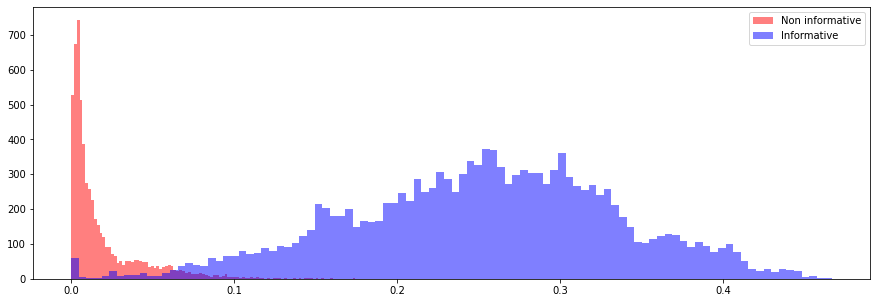

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(15,5))
ni_counts = plt.hist(nict_areas, color='red',bins=100, alpha=0.5)
plt.hist(ict_areas, color='blue', bins=100, alpha=0.5)
plt.legend(['Non informative', 'Informative'])
plt.show()
plt.savefig('areas distribution.png')

In [ ]:
density, bins = np.histogram(nict_areas, bins=100)
ni_x = bins[:-1]
ni_y = density
density, bins = np.histogram(ict_areas, bins=100)
i_x = bins[:-1]
i_y = density

ni_interp = interpolate.interpolate.interp1d(ni_x, ni_y, kind="cubic")
i_interp = interpolate.interpolate.interp1d(i_x, i_y, kind="cubic")

In [ ]:
ni_extended_x = np.linspace(min(ni_x), max(ni_x), 100000)
i_extended_x = np.linspace(min(i_x), max(i_x), 100000)

threshold_y = np.inf
threshold = None

for x in ni_extended_x:
  i_count = i_interp(x)
  ni_count = ni_interp(x)
  diff = abs(i_count - ni_count)
  if diff < threshold_y:
    threshold = x
    threshold_y = min(threshold_y, diff)
threshold, threshold_y

(0.06216381183769072, 0.003651115714674802)

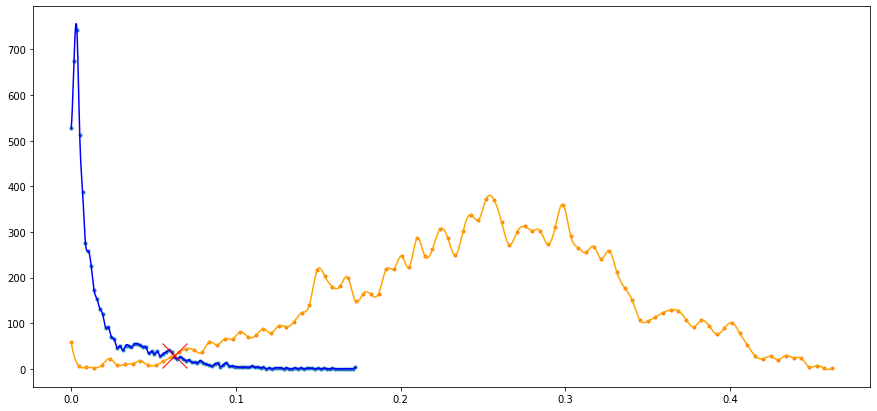

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(ni_x, ni_y, marker='o', linestyle="None", markersize=3)
plt.plot(i_x, i_y, marker='o', linestyle="None", markersize=3)

plt.plot(ni_extended_x, ni_interp(ni_extended_x), 'blue')
plt.plot(i_extended_x, i_interp(i_extended_x), 'orange')
plt.plot(threshold, ni_interp(threshold), marker="x", ms=25, color="red")
plt.show()

In [ ]:
def remove_slices_under_threshold(imgs_path):
  slices = os.listdir(imgs_path)
  for slice_name in slices:
    slice_path = os.path.join(imgs_path, slice_name)
    slice = cv2.imread(slice_path)
    cropped = crop(slice)
    body_area = np.sum(cropped > 0)
    segmented = segment_lungs(cropped)
    lungs_area = np.sum(segmented)
    lungs_rel_area = lungs_area / body_area
    if  lungs_rel_area > threshold:
      segmented *= 255
      cv2.imwrite(slice_path, segmented)
    else:
      if os.path.exists(slice_path):
        os.remove(slice_path)

In [ ]:
# for patient in os.listdir(POSITIVE_DIR):
#   path = os.path.join(POSITIVE_DIR, patient)
#   remove_slices_under_threshold(path)

In [ ]:
# for patient in os.listdir(NEGATIVE_DIR):
#   path = os.path.join(NEGATIVE_DIR, patient)
#   remove_slices_under_threshold(path)

9903357


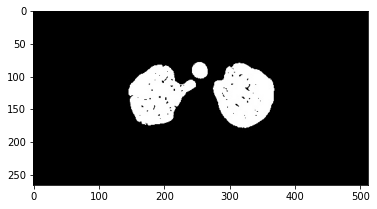

In [ ]:
path = NEGATIVE_DIR + "/Patient 1170/IMG-0001-00029.jpg"

img = cv2.imread(path)
plt.imshow(img, cmap='gray')
print(np.sum(img))

## Slice distribution

Slices per patient:
Min: 36
Max: 348
Mean: 181
Mode: 193
SD: 53


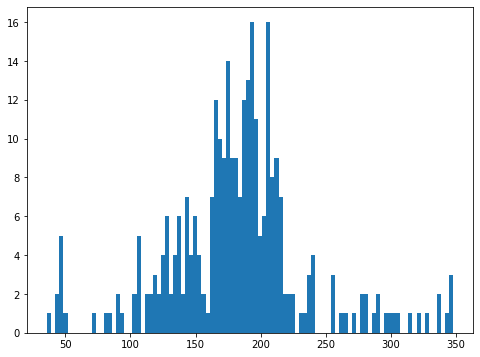

In [ ]:
slices_per_patient = []
scans_per_patient = []

for patient in os.listdir(POSITIVE_DIR):
  patient_path = os.path.join(POSITIVE_DIR, patient)
  imgs = os.listdir(patient_path)
  scans = set([])
  for img in imgs:
    scans.add('-'.join(imgs[0].split('-')[:2]))
  slices_per_patient.append(len(imgs))
  scans_per_patient.append(len(scans))


for patient in os.listdir(NEGATIVE_DIR):
  patient_path = os.path.join(NEGATIVE_DIR, patient)
  slices_per_patient.append(len(os.listdir(patient_path)))
  imgs = os.listdir(patient_path)
  scans = set([])
  for img in imgs:
    scans.add('-'.join(imgs[0].split('-')[:2]))
  slices_per_patient.append(len(imgs))
  scans_per_patient.append(len(scans))

print("Slices per patient:")
print("Min: {}".format(min(slices_per_patient)))
print("Max: {}".format(max(slices_per_patient)))
print("Mean: {}".format(int(np.floor(np.mean(slices_per_patient)))))
print('Mode: {}'.format(stats.mode(slices_per_patient)[0][0]))
print("SD: {}".format(int(np.floor(np.std(slices_per_patient)))))

x = sorted(slices_per_patient)
fig = plt.figure(figsize = (8, 6))
plt.hist(x, bins=100)
plt.show()

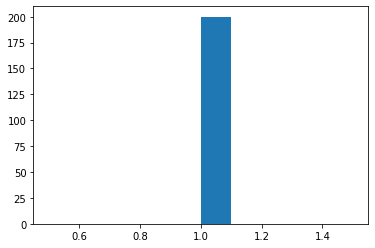

In [ ]:
plt.hist(scans_per_patient)
plt.show()

## Saving segmented images

In [11]:
IMG_DIM = 224
IMG_DEPTH = 64

In [12]:
def concatenate_informative_slices(images, is_informative):
  scan = np.array([])
  for i, img in enumerate(images):
    if is_informative[i] == 1:
      img = np.expand_dims(img, -1)
      if len(scan) == 0:
        scan = img
      scan = np.concatenate((scan, img), axis = -1)
  return scan

def resize_scan(scan, img_dim = 224, img_depth = 64):
  if scan.shape[-1] >= img_depth:
    indices = list(np.linspace(0, scan.shape[-1]-1, img_depth, dtype=int))
    scan = scan[:, :, indices]
  else:
    desired_width = img_dim
    desired_height = img_dim
    desired_depth = IMG_DEPTH

    current_width = scan.shape[0]
    current_height = scan.shape[1]
    current_depth = scan.shape[2]
    
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    scan = ndimage.zoom(scan, zoom = (width_factor, height_factor, depth_factor), order = 1)
  return scan

def save_scan(scan, target_dir):
  scan *= 255 
  if not os.path.exists(target_dir):
    os.makedirs(target_dir)
  for i in range(scan.shape[-1]):
    img = scan[...,i]
    cv2.imwrite(os.path.join(target_dir, f'{i}.jpg'), img)

# def process_scan(patient_path):
#   scan = read_scan(patient_path)
#   scan = resize_scan(scan)
#   scan = tf.expand_dims(scan, axis=-1)
#   return scan

In [13]:
with open('./data/multiple_scans_patients.txt', 'r') as f:
  MULTIPLE_SCANS_PATIENS = json.load(f)
MULTIPLE_SCANS_PATIENS

{'Patient 1072': 'IMG-0005',
 'Patient 208': 'IMG-0002',
 'Patient 220': 'IMG-0002',
 'Patient 230': 'IMG-0002',
 'Patient 836': 'IMG-0005',
 'Patient 927': 'IMG-0002'}

In [22]:
slices = []
slice_names = []
is_informative = []

num_patients = 20

for patient_zip in os.listdir(PATIENTS_DIR):
  patient_path = os.path.join(PATIENTS_DIR, patient_zip)
  patient_id = patient_zip.split('.zip')[0]
  patient_npy = patient_zip.replace('zip', 'npy')
  target_path = os.path.join(PREPROCESSED_DIR, patient_npy)

  if patient_npy in os.listdir(PREPROCESSED_DIR):
    continue

  with ZipFile(patient_path, 'r') as zip:
    img_list = [img for img in zip.namelist() if 'IMG' in img]
    if patient_id in MULTIPLE_SCANS_PATIENS.keys():
      biggest_scan = MULTIPLE_SCANS_PATIENS[patient_id]
      img_list = [img for img in img_list if biggest_scan in img]
      
    for img_path in img_list:
      img_path = zip.extract(img_path)

      slice_names.append(img_path.split('/')[-1])
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      cropped = crop(img)
      segmented = segment_lungs(cropped)

      body_area = np.sum(cropped > 0)
      lungs_area = np.sum(segmented)
      relative_area = lungs_area / body_area

      segmented = to_square_shape(segmented).astype(np.float32)
      segmented = cv2.resize(segmented, (IMG_DIM, IMG_DIM)).astype(np.uint8) 

      slices.append(segmented)
      is_informative.append(1 if relative_area > 0.05 else 0)

    is_informative = list(signal.medfilt(is_informative, kernel_size=5).astype(np.int))
    scan = concatenate_informative_slices(slices, is_informative)
    scan = resize_scan(scan, IMG_DIM, IMG_DEPTH)
    np.save(target_path, scan)

  num_patients -= 1 
  if num_patients == 0:
    break

In [23]:
len(os.listdir(PREPROCESSED_DIR))

100

# Loading data and preprocessing

In [ ]:
IMG_DIM = 128
IMG_DEPTH = 64

# Build train and validation datasets

In [ ]:
scan_paths = [os.path.join(PREPROCESSED_DIR, patient_dir) for patient_dir in os.listdir(PREPROCESSED_DIR)]

In [ ]:
# To delete than segment all scans
scans_id = [patient_dir for patient_dir in os.listdir(PREPROCESSED_DIR)]
df = feature_frame.copy()

for i in feature_frame.index:
  if not feature_frame.at[i, 'id'] in scans_id:
    df.drop(index = i, inplace = True)
  # else:
  #   df.at[i, 'Label2-SARS-CoV-2 nucleic acids'].replace(
  #       to_replace = {'Positive':1, 'Negative':0}, implace = True)

df['Label2-SARS-CoV-2 nucleic acids'].replace(to_replace = {'Positive':1, 'Negative':0}, inplace = True)
df

,id,Label1-Mortality outcome,Label2-SARS-CoV-2 nucleic acids,Age,Body temperature,Gender,Dementia,Brain surgery,Brain stem hemorrhage,Cerebral atherosclerosis,Cerebral hemorrhage,Cerebral infarction,Intracranial aneurysm,Lacunar infarction,Aphasia,Organic mental disorders,Pituitary adenoma,Subdural effusion,Subdural hemorrhage,Parkinson Disease,Encephalopathy,Myasthenia gravis,Gastrointestinal surgery for neoplasia,Adjuvant Chemotherapy for gastrointestinal tumor,Intestinal obstruction,Radio-chemotherapy,Gastritis,Non specified chronic stomach disease,Gastrointestinal bleeding,Gastrointestinal Ulcer,Gastroesophageal reflux,Gastric cancer,Inguinal hernia,Gastrointestinal surgery,Arrhythmia,Coronary disease,Heart failure,Cardiomyopathy,Hypertension,Hypertensive heart disease,...,TT Value in range,FIB Value,FIB Value in range,APTT Value,APTT Value in range,INR Value,INR Value in range,PT Value,PT Value in range,ALP Value,ALP Value in range,ALT Value,ALT Value in range,AST Value,AST Value in range,CA Value,CA Value in range,CL Value,CL Value in range,CO2 Value,CO2 Value in range,CREA Value,CREA Value in range,GLB Value,GLB Value in range,K Value,K Value in range,MG Value,MG Value in range,Na Value,Na Value in range,PHOS Value,PHOS Value in range,TBIL Value,TBIL Value in range,TP Value,TP Value in range,URIC Value,URIC Value in range,Unnamed: 252
66,Patient 67,Unknown,1,63,36.8,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0.705000,0,0.761290,0,0.490196,0,0.50,0,0.236364,0,0.885714,0,0.437500,0,0.392157,0,0.275000,0,0.788889,0,0.135955,0,-0.01000,-1,-0.017647,-1,0.250000,0,0.888889,0,0.378788,0,0.992806,0,-0.126316,-1,0.011818,0,78
72,Patient 73,Cured,1,55,38.5,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,-0.590000,-1,0.993548,0,0.901961,0,0.92,0,0.224416,0,0.539056,0,0.456437,0,0.320210,0,0.529030,0,0.475200,0,0.397644,0,0.32080,0,0.284771,0,0.435944,0,0.437411,0,0.384242,0,1.770566,1,-0.273714,-1,0.482354,0,78
73,Patient 74,Cured,1,33,38.6,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1.900000,1,0.548387,0,0.215686,0,0.22,0,0.009091,0,0.342857,0,0.468750,0,0.215686,0,0.258333,0,0.600000,0,0.286517,0,0.37000,0,0.147059,0,0.625000,0,0.300000,0,-0.212121,-1,0.223022,0,-0.042105,-1,-0.125000,-1,78
74,Patient 75,Cured,1,68,38.0,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.780000,0,0.651613,0,0.352941,0,0.36,0,0.222297,0,0.366429,0,0.333810,0,0.309706,0,0.683636,0,0.410611,0,0.168511,0,0.47070,0,0.263960,0,0.380019,0,0.555278,0,0.283939,0,0.293466,0,-0.142068,-1,0.282079,0,78
75,Patient 76,Cured,1,81,38.0,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.585000,0,0.767742,0,0.607843,0,0.62,0,0.321209,0,0.437697,0,0.474372,0,0.439538,0,0.484659,0,0.502167,0,0.251367,0,0.40900,0,0.279564,0,0.443528,0,0.354189,0,0.217727,0,0.476949,0,-0.173147,-1,0.410301,0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,Patient 1206,Cured,1,67,37.5,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,2.340000,1,1.232258,1,0.352941,0,0.36,0,0.329915,0,0.422767,0,0.388373,0,0.263263,0,0.372053,0,0.509078,0,0.200596,0,0.47135,0,0.283837,0,0.426315,0,0.320511,0,0.340606,0,0.481152,0,-0.456179,-1,0.226962,0,78
1206,Patient 1207,Cured,1,68,36.6,Female,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0.738133,0,0.586766,0,0.490196,0,0.50,0,0.256552,0,0.365199,0,0.320035,0,0.350322,0,0.539741,0,0.493222,0,0.160813,0,0.49780,0,0.372493,0,0.393731,0,0.524122,0,0.252576,0,0.412324,0,-0.122821,-1,0.181330,0,78
1207,Patient 1208,Cured,1,76,37.9,Male,0,0,0,0,0,0

In [ ]:
df['Label2-SARS-CoV-2 nucleic acids'].value_counts()

1    136
0     64
Name: Label2-SARS-CoV-2 nucleic acids, dtype: int64

In [ ]:
class ScanGenerator(tf.keras.utils.Sequence):

  def __init__(self, df, directory = None, x_col = 'id', y_col = 'Label2-SARS-CoV-2 nucleic acids', target_size = (128, 128),
                batch_size = 2, shuffle = True, seed = None):
    self.df = df
    self.x_col = x_col
    self.y_col = y_col
    self.target_size = target_size
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.seed = seed

    self.df.reset_index(drop = True, inplace = True)
    self.on_epoch_end()
  
  def __len__(self):
    return math.ceil(len(self.df.index) / self.batch_size)
  
  def on_epoch_end(self):
    if self.shuffle:
      self.df = self.df.sample(frac = 1).reset_index(drop = True)
  
  def __getitem__(self, idx):
    batch_df = self.df[idx * self.batch_size:(idx + 1) * self.batch_size]
    y_batch = batch_df['Label2-SARS-CoV-2 nucleic acids'].values
    scan_paths = [os.path.join(PREPROCESSED_DIR, path) for path in batch_df['id']]
    
    x_batch = np.array([np.load(path) for path in scan_paths])
    return (x_batch, y_batch)

In [ ]:
train_gen = ScanGenerator(df, PREPROCESSED_DIR, batch_size=8)
batch = train_gen.__getitem__(0)
scan= batch[0][0]
label = batch[1][0]
scan = np.squeeze(scan)
plt.imshow(scan[:, :, 30], cmap = 'gray')
plt.title(label)
plt.axis('off')
plt.show()

IsADirectoryError: ignored

# Data visualization

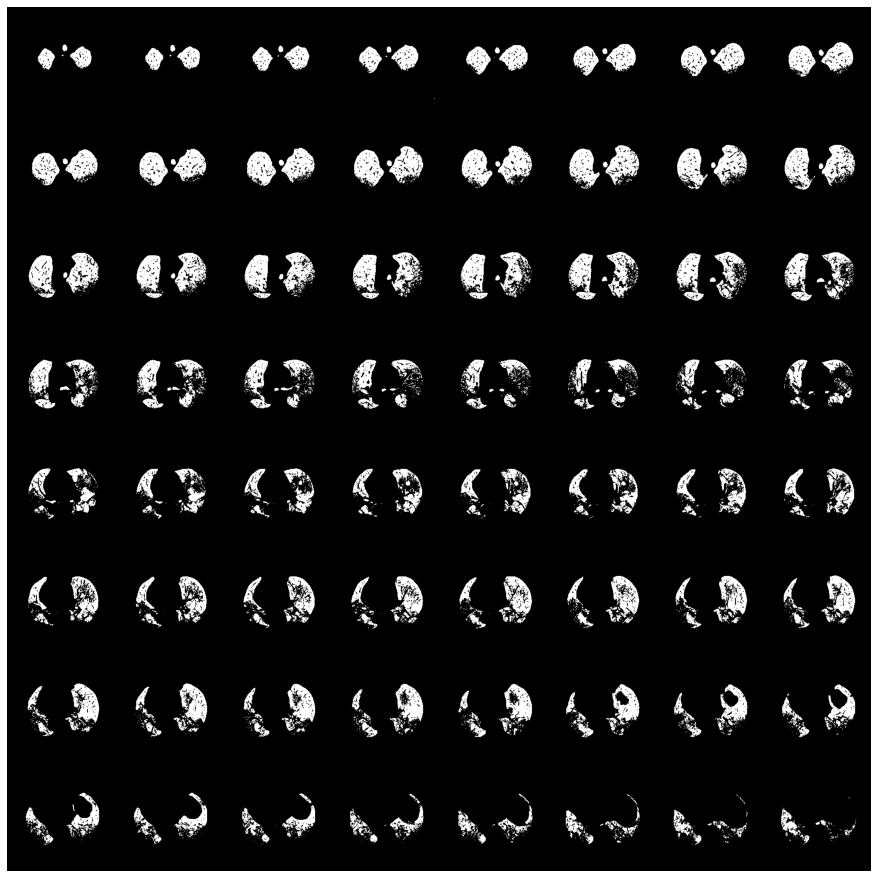

In [21]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    # print(data.shape())
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
scan = np.load(os.path.join(PREPROCESSED_DIR, os.listdir(PREPROCESSED_DIR)[0]))
plot_slices(8, 8, IMG_DIM, IMG_DIM, scan[:, :, :])

# Define a 3D convolutional neural network

In [ ]:
def create_model(width = 128, height = 128, depth = 64):

  input = x = Input((width, height, depth, 1))
  
  x = Conv3D(filters = 64, kernel_size = (3, 3, 3), activation = 'relu')(x)
  x = MaxPool3D(pool_size = (2, 2, 2))(x)
  x = BatchNormalization()(x)

  x = Conv3D(filters = 64, kernel_size = (3, 3, 3), activation = 'relu')(x)
  x = MaxPool3D(pool_size = (2, 2, 2))(x)
  x = BatchNormalization()(x)

  x = Conv3D(filters = 128, kernel_size = (3, 3, 3), activation = 'relu')(x)
  x = MaxPool3D(pool_size = (2, 2, 2))(x)
  x = BatchNormalization()(x)

  x = Conv3D(filters = 256, kernel_size = (3, 3, 3), activation = 'relu')(x)
  x = MaxPool3D(pool_size = (2, 2, 2))(x)
  x = BatchNormalization()(x)

  x = GlobalAveragePooling3D()(x)
  x = Dense(units = 512, activation = 'relu')(x)
  x = Dropout(0.3)(x)

  output = Dense(units = 1, activation = 'sigmoid')(x)

  model = Model(input, output)
  return model

In [ ]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

# Train model

In [ ]:
# initial_learning_rate = 0.0001
initial_learning_rate = 0.001


lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    optimizer = Adam(learning_rate = lr_schedule),
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

MODELS_DIR = os.path.join(os.getcwd(), 'saved model')
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)

checkpoint_cb = ModelCheckpoint(os.path.join(MODELS_DIR, 'ct_model.h5'), save_best_only = True)
early_stopping_cb = EarlyStopping(monitor = 'val_acc', patience = 5)

In [ ]:
BS = 16

train_df, val_df = train_test_split(df, test_size = 0.3)
train_gen = ScanGenerator(train_df, PREPROCESSED_DIR, batch_size=BS)
val_gen = ScanGenerator(val_df, PREPROCESSED_DIR, batch_size=BS)

epochs = 100
history = model.fit(
    train_gen,
    epochs = epochs,
    callbacks = [checkpoint_cb, early_stopping_cb],
    validation_data = val_gen,
    verbose = 1
).history

In [ ]:
plot_history(history)